<a href="https://colab.research.google.com/github/abheekd/Leetcode-Google/blob/master/HiFIC_torch_colab_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HiFIC Demo
Compress arbitrary images in Colab using a pretrained neural compression model. This is a Pytorch port of the [High-Fidelity Image Compression](https://hific.github.io/) project - see the [Github repo](https://github.com/Justin-Tan/high-fidelity-generative-compression) for the source.

Execute all cells in sequence to see the results of compression on a default image, or upload your own images to be compressed by following the steps in the notebook.

Some sample reconstructions from the compressed format can be found [here](https://github.com/Justin-Tan/high-fidelity-generative-compression/blob/master/assets/EXAMPLES.md). For detailed usage instructions please see [the user's guide](https://github.com/Justin-Tan/high-fidelity-generative-compression/blob/master/assets/USAGE_GUIDE.md).


## Setup Colab Environment

In [1]:
import torch
import numpy as np

import os
import glob
import urllib
import zipfile
import collections

from google.colab import files
from PIL import Image
from IPython.display import Image as DisplayImage
from IPython.display import Javascript
from IPython.core.display import display, HTML

INPUT_DIR = '/content/files'
STAGING_DIR = '/content/stage'
OUT_DIR = '/content/out'
CKPT_DIR = '/content/checkpoint'
DEFAULT_IMAGE_PREFIX = ('https://storage.googleapis.com/hific/clic2020/images/originals/')

File = collections.namedtuple('File', ['output_path', 'compressed_path',
                                       'num_bytes', 'bpp'])

_ = [os.makedirs(dir, exist_ok=True) for dir in (INPUT_DIR, STAGING_DIR, OUT_DIR,
                                                 CKPT_DIR)]
original_sizes = dict()

In [2]:
def get_default_image(output_dir, image_choice="portrait"):
    image_ID = dict(cafe="b1b8f33917a40c9d0b118ef801de67d4.png",
                    cat="4fa92b8ecb4ee46a942837447de1ac5c.png",
                    city="b98ec5b29d02ef65e57d23ef90660b4d.png",
                    clocktower="9cbf2594f339c0d3d0f0ea25c62af52b.png",
                    fresco="8181526d9f238726d3e1d3ec3cc56fb7.png",
                    islet="c6658d87c608b631f5cc3fb5a8d89731.png",
                    mountain="d3688a7285d7b2b81febe1cd72e6e22c.png",
                    pasta="f5be5054c01d8efc834d78a991356ad6.png",
                    pines="e903c4f4684100a6dbac1f0b9b4de760.png",
                    plaza="d78b363974ac79908b79012f48de715d.png",
                    portrait="ad249bba099568403dc6b97bc37f8d74.png",
                    shoreline="b9bad0c68eb9ce94e02e9698c8cc429a.png",
                    street="90b622e11ecc37edd42297427403ee81.png",
                    tundra="cc831c904a314a0e98530124526e930b.png",
                    )[image_choice]

    default_image_url = os.path.join(DEFAULT_IMAGE_PREFIX, image_ID)
    output_path = os.path.join(output_dir, os.path.basename(default_image_url))
    print('Downloading', default_image_url, '\n->', output_path)
    urllib.request.urlretrieve(default_image_url, output_path)

def get_model_checkpoint(output_dir, model_ID, model_choice, alternative=False,
                         overwrite=False):
    output_path = os.path.join(output_dir, f'{model_choice.lower()}.pt')
    if overwrite is True:
        print('Overwriting file, if it exists.')
        !rm -v $output_path
    else:
        if os.path.exists(output_path):
            print('File already exists at', '\n->', output_path)
            return output_path
    print('Downloading model to', '\n->', output_path)
    if alternative is True:
        !wget "https://zenodo.org/record/4026003/files/$model_ID" -O $output_path
    else:
        !wget -q --show-progress --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=$model_ID' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=$model_ID" -O $output_path && rm -rf /tmp/cookies.txt

    return output_path

## Select Model
Higher bitrates result in higher-fidelity reconstructions, at the expense of increased message length. `HIFIC-low` is the model with the highest compression ratio (lowest output filesize), and `HIFIC-high` is the model with the lowest compression ratio.

In [3]:
# Enter choice to right
model_choice = 'HIFIC-low' #@param ["HIFIC-low", "HIFIC-med", "HIFIC-high"]


Clone repo and grab the model checkpoint (around 2 GB). Please check the downloaded filesize carefully - see below.

In [13]:
# Drive IDs
model_choices = {'HIFIC-low': '1hfFTkZbs_VOBmXQ-M4bYEPejrD76lAY9',
                 'HIFIC-med': '1QNoX0AGKTBkthMJGPfQI0dT0_tnysYUb',
                 'HIFIC-high': '1BFYpvhVIA_Ek2QsHBbKnaBE8wn1GhFyA'}

model_ID = model_choices[model_choice]
model_path = get_model_checkpoint(CKPT_DIR, model_ID, model_choice)
first_model_init = False

File already exists at 
-> /content/checkpoint/hific-low.pt


In [14]:
# Checkpoints should be around 2GB in size - if not, run the next
# cell to download models from an alternate host
!ls -ltrh /content/checkpoint

total 4.0K
-rw-r--r-- 1 root root 2.4K May 20 12:38 hific-low.pt


During periods of high traffic the download quota for Google Drive may be temporarily exceeded. Please check (`ls -ltrh /content/checkpoint`) if the checkpoints are around 1.5GB - 2 GB in size. If the filesize is in kB, run the cell below this to download the model checkpoints from Zenodo - this may be slower but more robust.

In [15]:
# Don't run this if the download from Drive was successful!
model_choices = {'HIFIC-low': 'hific_low.pt?download=1',
                 'HIFIC-med': 'hific_med.pt?download=1',
                 'HIFIC-high': 'hific_hi.pt?download=1'}

model_ID = model_choices[model_choice]
model_path = get_model_checkpoint(CKPT_DIR, model_ID, model_choice,
                                  alternative=True, overwrite=True)
first_model_init = False

Overwriting file, if it exists.
removed '/content/checkpoint/hific-low.pt'
-> /content/checkpoint/hific-low.pt
--2025-05-20 12:41:22--  https://zenodo.org/record/4026003/files/hific_low.pt?download=1
Resolving zenodo.org (zenodo.org)... 188.185.43.25, 188.185.45.92, 188.185.48.194, ...
Connecting to zenodo.org (zenodo.org)|188.185.43.25|:443... connected.
HTTP request sent, awaiting response... 301 MOVED PERMANENTLY
Location: /records/4026003/files/hific_low.pt [following]
--2025-05-20 12:41:22--  https://zenodo.org/records/4026003/files/hific_low.pt
Reusing existing connection to zenodo.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 1813144103 (1.7G) [application/octet-stream]
Saving to: ‘/content/checkpoint/hific-low.pt’

/content/checkpoint 100%[===================>]   1.69G  78.8MB/s    in 27s     

2025-05-20 12:41:49 (63.0 MB/s) - ‘/content/checkpoint/hific-low.pt’ saved [1813144103/1813144103]



In [16]:
# Checkpoints should be around 2GB in size
!ls -ltrh /content/checkpoint

total 1.7G
-rw-r--r-- 1 root root 1.7G May 20 12:41 hific-low.pt


In [17]:
!git clone https://github.com/Justin-Tan/high-fidelity-generative-compression.git
%cd high-fidelity-generative-compression/
from compress import prepare_model, prepare_dataloader, compress_and_save, load_and_decompress, compress_and_decompress

Cloning into 'high-fidelity-generative-compression'...
remote: Enumerating objects: 1804, done.
remote: Counting objects: 100% (29/29), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 1804 (delta 15), reused 24 (delta 14), pack-reused 1775 (from 1)
Receiving objects: 100% (1804/1804), 86.07 MiB | 39.42 MiB/s, done.
Resolving deltas: 100% (1231/1231), done.
/content/high-fidelity-generative-compression/high-fidelity-generative-compression


ImportError: cannot import name 'compare_ssim' from 'skimage.measure' (/usr/local/lib/python3.11/dist-packages/skimage/measure/__init__.py)

## Prepare Images

To upload your own images (JPG or PNG without alpha channels), set `custom_image=True` in the following cell. Otherwise, we'll use a default image from the CLIC2020 Compression Challenge dataset.

Alternatively, you can use the `Files` tab on the left and select the `Upload to session storage` icon to upload more custom images.

In [8]:
custom_image = True #@param ["False", "True"] {type:"raw"}

In [ ]:
# Choose default images from CLIC2020 dataset
# Skip if uploading custom images
default_image = "portrait" #@param ["cafe", "cat", "city", "clocktower", "fresco", "islet", "mountain", "pasta", "pines", "plaza", "portrait", "shoreline", "street", "tundra"]

Using user-defined images.


Saving primary-hero-nuk-lg.webp to primary-hero-nuk-lg.webp
User uploaded file "primary-hero-nuk-lg.webp" with length 57422 bytes
renamed 'primary-hero-nuk-lg.webp' -> '/content/files/primary-hero-nuk-lg.webp'
Got following files (1):
-> primary-hero-nuk-lg.webp:


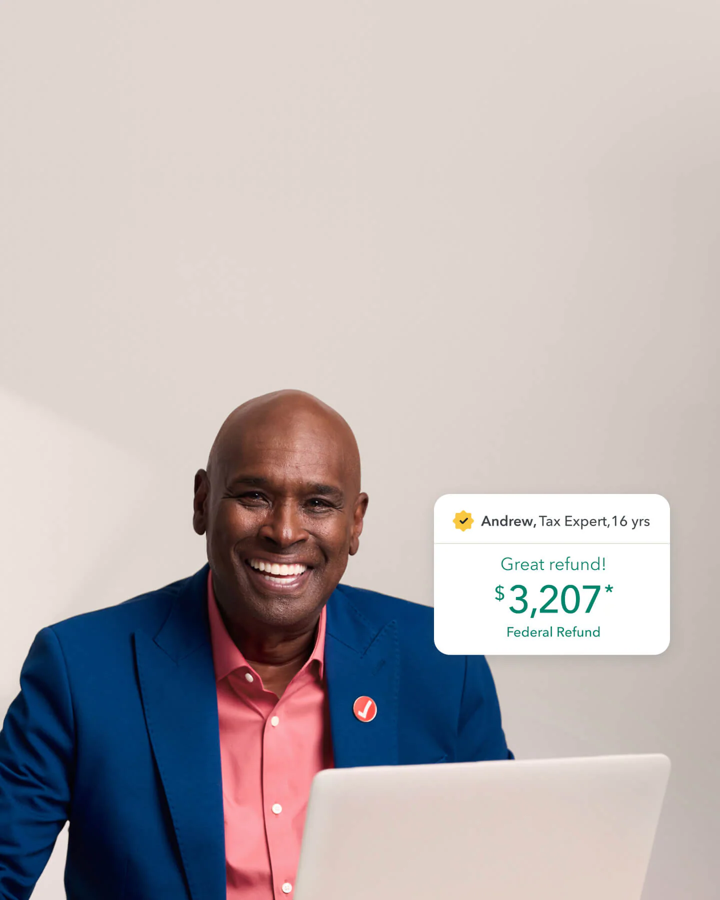

In [9]:
if custom_image is True:
    print('Using user-defined images.')
    # Get dict of upload files
    uploaded = files.upload()

    for fn in uploaded.keys():
        print('User uploaded file "{name}" with length {length} bytes'.format(
            name=fn, length=len(uploaded[fn])))
        !mv -iv $fn $INPUT_DIR
else:
    print('Using default image.')
    # Download default image
    get_default_image(INPUT_DIR, default_image)

all_files = os.listdir(INPUT_DIR)
print(f'Got following files ({len(all_files)}):')
scale_factor = 2 if len(all_files) == 1 else 4

for file_name in all_files:
    img = Image.open(os.path.join(INPUT_DIR, file_name))
    w, h = img.size
    img = img.resize((w // scale_factor, h // scale_factor))
    print('-> ' + file_name + ':')
    display(img)

In [10]:
SUPPORTED_EXT = {'.png', '.jpg'}

all_files = os.listdir(INPUT_DIR)
if not all_files:
    raise ValueError("Please upload/download images!")

def get_bpp(image_dimensions, num_bytes):
    w, h = image_dimensions
    return num_bytes * 8 / (w * h)

def has_alpha(img_p):
    im = Image.open(img_p)
    return im.mode == 'RGBA'

!rm -v $STAGING_DIR/*

for file_name in all_files:
    if os.path.isdir(file_name):
        continue
    if not any(file_name.endswith(ext) for ext in SUPPORTED_EXT):
        print('Skipping non-image', file_name, '...')
        continue
    full_path = os.path.join(INPUT_DIR, file_name)
    if has_alpha(full_path) is True:
        print('Skipping because of alpha channel:', file_name)
        continue

    file_name, _ = os.path.splitext(file_name)
    original_sizes[file_name] = os.path.getsize(full_path)
    output_path = os.path.join(OUT_DIR, f'{file_name}.png')
    !mv -v $full_path $STAGING_DIR

rm: cannot remove '/content/stage/*': No such file or directory
Skipping non-image primary-hero-nuk-lg.webp ...


## Enabling GPU

GPU should be enabled for this Colab. If the next cell prints a warning, do the following:
- Navigate to `Edit →> Notebook Settings`
- Select GPU from the Hardware Accelerator drop-down


In [11]:
if torch.cuda.is_available() is False:
  print('WARNING: No GPU found. Compression/decompression will be slow!')
else:
  print(f'Found GPU {torch.cuda.get_device_name(0)}')

Found GPU Tesla T4


# Compress Images
Note: Models can take up to a minute to load on Colab, depending on the allocated GPU and chosen model - you only need to run the following cell once per session.



In [12]:
# Setup model
if first_model_init is False:
    print('Building model ...')
    model, args = prepare_model(model_path, STAGING_DIR)
    first_model_init = True

Building model ...


NameError: name 'prepare_model' is not defined

Encode images and save compressed format to disk. Note: depending on the allocated GPU, large images (`>~ 4000x4000 px`) may throw an OOM error.

In [ ]:
%%time
data_loader = prepare_dataloader(args, STAGING_DIR, OUT_DIR)
compress_and_save(model, args, data_loader, OUT_DIR)

In [ ]:
# Check compressed filesizes
!ls -ltrh $OUT_DIR

Load compressed format from disk and decode

In [ ]:
all_outputs = []

for compressed_file in glob.glob(os.path.join(OUT_DIR, '*.hfc')):
    file_name, _ = os.path.splitext(compressed_file)
    output_path = os.path.join(OUT_DIR, f'{file_name}.png')

    # Model decode
    reconstruction = load_and_decompress(model, compressed_file, output_path)

    all_outputs.append(File(output_path=output_path,
                            compressed_path=compressed_file,
                            num_bytes=os.path.getsize(compressed_file),
                            bpp=get_bpp(Image.open(output_path).size, os.path.getsize(compressed_file))))

torch.cuda.empty_cache()

# Show output

In [ ]:
def print_html(html):
    display(HTML(html + '<br/>'))

def make_cell_large():
    display(Javascript(
        '''google.colab.output.setIframeHeight(0, true, {maxHeight: 5192})'''))

make_cell_large()  # Larger output window.

for file in all_outputs:
    print_html('<hr/>')
    file_name, _ = os.path.splitext(file.output_path)
    original_size = original_sizes[os.path.basename(file_name).split('_compressed')[0]]
    print(f'Showing {file.output_path} | {file.num_bytes//1000} kB (compressed) | {file.bpp:.4f} bpp | Original: {original_size//1000} kB')
    display(Image.open(file.output_path))
    print_html('<hr/>')

You can compress new images by going back to the "Prepare Images" heading and selecting a different default image or upload your own for compression, then running the cells below in sequence. Note that each model cannot decompress the output generated by a different model, and you need to delete the contents of `/content/out` if you want to try a different model.

Please open an issue if you encounter an error when running this demo.

### Download compressed images

Note: Files are losslessly saved as PNG for viewing.


In [ ]:
download_outputs = True #@param ["False", "True"] {type:"raw"}

In [ ]:
if download_outputs is True:
    ZIP = '/content/hific_compressed_images.zip'

    with zipfile.ZipFile(ZIP, 'w') as zf:
        for f in all_outputs:
            path_with_bpp = f.output_path.replace('.png', f'-{f.bpp:.3f}bpp.png')
            zf.write(f.output_path, os.path.basename(path_with_bpp))

    files.download(ZIP)

# Citation

This is a re-implementation of the orignal paper. Please cite the [original paper](https://arxiv.org/abs/2006.09965) if you use their work.

```bash
@article{mentzer2020high,
  title={High-Fidelity Generative Image Compression},
  author={Mentzer, Fabian and Toderici, George and Tschannen, Michael and Agustsson, Eirikur},
  journal={arXiv preprint arXiv:2006.09965},
  year={2020}
}
```